# K-means and Gaussian Mixture Models: Examples of the EM Algorithm #
    - Matt Robinson

# K-means Clustering

I will implement the batch-version of the algorithm below.

Most of the details are adapted from Bishop (2006).

In k-means clustering, we are trying to minimize an obejective function, or *distortion measure*, $J$:

$$
J = \sum _ { n = 1 } ^ { N } \sum _ { k = 1 } ^ { K } r _ { n k } \left\| \mathbf { x } _ { n } - \boldsymbol { \mu } _ { k } \right\| ^ { 2 }
$$

where $N$ is the number of data points and $K$ is the chosen number of clusters. $r _ { n k } \in \{ 0,1 \}$ is a binary indicator variable that tells us which of the clusters $1,...,K$ the data point $\mathbf{x}_n$ has been assigned to. Finally, $\mathbf{\mu}_k$ is the "cluster center" or prototype vector associated with cluster $k$.

We wish to find the $r _ { n k }$ and $\mathbf{\mu}_k$ that minimize $J$. To accomplish this, we use a two step process.

**Step 0.** Pick the number of clusters $K$ and choose initial values for the $\mathbf{\mu}_k$

**Repeat Until Converged:** 

$\quad$ **(Expectation)** Minimize $J$ with respect to the $r_{nk}$, while keeping the $\mathbf{\mu}_k$ fixed.

$\quad$ **(Maximization)** Minimize $J$ with respect to the $\mathbf{\mu}_k$, while keeping the $r_{nk}$ fixed.

More formally, we can write the mathematical steps needed to perform each step:

$$
\begin{align*}
\quad \text{(Expectation)} \quad r _ { n k } &= \left\{ \begin{array} { l l } { 1 } & { \text { if } k = \arg \min _ { j } \left\| \mathbf { x } _ { n } - \boldsymbol { \mu } _ { j } \right\| ^ { 2 } } \\ { 0 } & { \text { otherwise. } } \end{array} \right. \\
\quad \text{(Maximization)} \quad \boldsymbol { \mu } _ { k } &= \frac { \sum _ { n } r _ { n k } \mathbf { x } _ { n } } { \sum _ { n } r _ { n k } }
\end{align*}
$$

For the expectation step, $r_{nk}$ acts to assign each data point $\mathbf{x}_n$ to the cluster center that is closest to $\mathbf{x}_n$ in terms of Euclidean distance.

For the maximization step, one can see that the denominator $ { \sum _ { n } r _ { n k } }$ is just the number of points assigned to cluster $k$. Thus, $\mathbf{\mu}_k$ is just the mean of all of the data points assigned to cluster $k$. That's why it is called *k-means* clustering. 

Note that we are guarenteed convergence since each step necessarily decreases the distortion measure $J$. However, we are not guarenteed that the algoirthm convergest to a global minimum. Thus, it is often recommended that one runs the algorithm a couple of times to see if the results differ much between runs.

Let's now try to implement the algorithm:

In [1]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns  # for plot styling
import numpy as np
import pandas as pd

In [2]:
class KMeans(object):

    def __init__(self, n_clusters=2, n_init=10, max_iter=300,
                    tol=0.0001, random_state=1):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
    def fit(self, X):
        
        n_samples, n_features = X.shape
        self.cluster_centers_ = np.empty((self.n_clusters, n_features), dtype=X.dtype)
        self.labels_ = np.empty((n_samples), dtype=X.dtype)
        
        self.inertia_ = 0
        
        # Randomly choose existing data points as clusters
        rng = np.random.RandomState(self.random_state)
        i = rng.permutation(X.shape[0])[:self.n_clusters]
        
        cluster_centers = X[i]
        old_cluster_centers = cluster_centers
        
        labels = np.empty((n_samples), dtype=X.dtype)
        
        intertia = 0
        
        for _ in range(self.max_iter):
            
            # Assign label based on closest cluster center
            for idx, sample in enumerate(X):
                labels[idx] = np.argmin(
                    [np.linalg.norm(sample - cluster_center) 
                     for cluster_center in cluster_centers]
                )
                
            # Find new centers from mean of points assigned to cluster
            cluster_centers = np.array([X[labels == i].mean(axis=0)
                                        for i in range(self.n_clusters)]
                                      )
            
            # Check if converged
            if (np.linalg.norm(cluster_centers-old_cluster_centers))**2 < self.tol:
                break
            else:
                old_cluster_centers = cluster_centers
                
                
        # update class variables
        self.cluster_centers_ = cluster_centers
        self.labels_ = labels
        
        return self
    
    
 

In [3]:
# get the Iris dataset from seaborn
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:4].values, df.iloc[:, 4].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [11]:
# train on only two features
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_std[:,0:2])
y_kmeans = kmeans.labels_

Text(0,0.5,'Sepal Width')

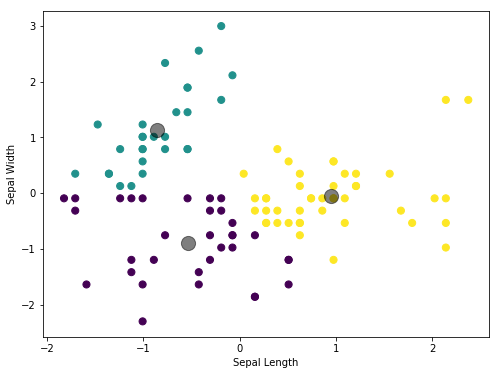

In [12]:
plt.figure(figsize=(8,6))

plt.scatter(X_train_std[:, 0], X_train_std[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")